## Introduction

Features are computed from a digitized image of a fine needle aspirate (FNA) of a breast mass. They describe characteristics of the cell nuclei present in the image. n the 3-dimensional space is that described in: [K. P. Bennett and O. L. Mangasarian: "Robust Linear Programming Discrimination of Two Linearly Inseparable Sets", Optimization Methods and Software 1, 1992, 23-34].

This database is also available through the UW CS ftp server: ftp ftp.cs.wisc.edu cd math-prog/cpo-dataset/machine-learn/WDBC/

Also can be found on UCI Machine Learning Repository: https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+%28Diagnostic%29

Attribute Information:

1) ID number 2) Diagnosis (M = malignant, B = benign) 3-32)

Ten real-valued features are computed for each cell nucleus:

- a) radius (mean of distances from center to points on the perimeter) 
- b) texture (standard deviation of gray-scale values) 
- c) perimeter 
- d) area 
- e) smoothness (local variation in radius lengths) 
- f) compactness (perimeter^2 / area - 1.0) 
- g) concavity (severity of concave portions of the contour) 
- h) concave points (number of concave portions of the contour) 
- i) symmetry 
- j) fractal dimension ("coastline approximation" - 1)

The mean, standard error and "worst" or largest (mean of the three largest values) of these features were computed for each image, resulting in 30 features. For instance, field 3 is Mean Radius, field 13 is Radius SE, field 23 is Worst Radius.

All feature values are recoded with four significant digits.

Missing attribute values: none

Class distribution: 357 benign, 212 malignant

## Import libraries

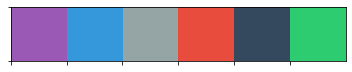

In [1]:
# Toolbox
import pandas as pd
import numpy as np
import random
import sys
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Statistics
from scipy.stats import norm
from scipy import stats

# Machine learning
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils import shuffle
from sklearn.preprocessing import MinMaxScaler, Normalizer
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

# Misc
import os
import warnings
warnings.filterwarnings(action='ignore')

# Preset data display
pd.options.display.max_seq_items = 1000
pd.options.display.max_rows =1000
pd.set_option('display.max_columns', 50)

# Set notebook colors and palette
flatui = ['#9b59b6', '#3498db', '#95a5a6', '#e74c3c', '#34495e', '#2ecc71']
sns.set_palette(flatui)
sns.palplot(sns.color_palette(flatui))
sns.set_style('white')
sns.set_color_codes(palette='deep')
# Favorite code to use: #34995e

In [2]:
import tensorflow as tf
import tensorflow.keras
import keras

print('These are the current versions working for me as of 2019-08-04')
print(f"TensorFlow Version: {tf.__version__}")
print(f"TensorFlow Keras Version: {tensorflow.keras.__version__}")
print(f"Keras Version: {keras.__version__}")
print()
print("TensorFlow-GPU is", "available" if tf.test.is_gpu_available() else "NOT AVAILABLE")
print(f"TensorFlow CUDA: {tf.test.is_built_with_cuda()}")
print(f"Tensorflow GPU Device Currently Activated: {tf.test.gpu_device_name()}")
print(f"Keras GPU: {keras.backend.tensorflow_backend._get_available_gpus()}")
print()
print(f"TF Session: {tf.Session()}")
print()
print(f"Python {sys.version}")

Using TensorFlow backend.


These are the current versions working for me as of 2019-08-04
TensorFlow Version: 1.13.1
TensorFlow Keras Version: 2.2.4-tf
Keras Version: 2.2.4

TensorFlow-GPU is available
TensorFlow CUDA: True
Tensorflow GPU Device Currently Activated: /device:GPU:0
Keras GPU: ['/job:localhost/replica:0/task:0/device:GPU:0']

TF Session: <tensorflow.python.client.session.Session object at 0x000001E4B044F668>

Python 3.6.8 |Anaconda, Inc.| (default, Feb 21 2019, 18:30:04) [MSC v.1916 64 bit (AMD64)]


### Define helpers

In [3]:
def pct_bar_labels():
    '''
    Function used to label the relative frequency on top of each bars
    '''
    # Set font size
    fs=15
    
    # Set plot label and ticks
    plt.ylabel('Relative Frequency (%)', fontsize=fs)
    plt.xticks(rotation=0, fontsize=fs)
    plt.yticks([])
    
    # Set individual bar labels in proportional scale
    for x in ax1.patches:
        ax1.annotate(str(x.get_height()) + '%', 
        (x.get_x() + x.get_width()/2., x.get_height()), ha='center', va='center', xytext=(0, 7), 
        textcoords='offset points', fontsize=fs, color='black')

def freq_table(var):
    '''
    Define plot global variables
    Create a function that will populate a frequency table (%)
    Get counts per feature then get the percentage over the total counts
    '''
    global ax, ax1
    
    # Get Values and pct and combine it into a dataframe
    count_freq = var.value_counts()
    pct_freq = round(var.value_counts(normalize=True)*100, 2)
    
    # Create a dataframe
    df = pd.DataFrame({'Count': count_freq, 'Percentage': pct_freq})
    
    # Print variable name
    print('Frequency of', var.name, ':')
    display(df)
    
    # Create plot
    ax1 = pct_freq.plot.bar(title='Percentage of {}'.format(var.name), figsize=(12,8))
    ax1.title.set_size(15)
    pct_bar_labels()
    plt.show()
    
# Define a null function
def get_nulls(df):
    
    # Get null pct and counts
    null_cols = pd.DataFrame(df.isnull().sum().sort_values(ascending=False), columns=['Null Data Count'])
    null_cols_pct = pd.DataFrame(round(df.isnull().sum().sort_values(ascending=False)/len(df),2), columns=['Null Data Pct'])

    # Combine dataframes horizontally
    null_cols_df = pd.DataFrame(pd.concat([null_cols, null_cols_pct], axis=1))

    all_nulls = null_cols_df[null_cols_df['Null Data Pct']>0]

    # Print
    print('There are', len(all_nulls), 'columns with missing values.')
    return all_nulls

# Define plot_nulls function
def plot_nulls(train):
    # Get null pct and counts
    null_cols = pd.DataFrame(train.isnull().sum().sort_values(ascending=False), columns=['Null Data Count'])
    null_cols_pct = pd.DataFrame(round(train.isnull().sum().sort_values(ascending=False)/len(train),2)*100, columns=['Null Data %'])

    # Combine horizontally (axis=1) into a dataframe with column names (keys=[]) then to a data frame
    null_cols_df = pd.DataFrame(pd.concat([null_cols, null_cols_pct], axis=1))

    all_nulls = null_cols_df[null_cols_df['Null Data %']>0]

    # Create figure space
    plt.figure(figsize=(12, 8))

    # Create plot
    sns.barplot(x=all_nulls.index,
                y='Null Data %',
                data=all_nulls)

    # Set plot features
    plt.xticks(rotation='90')
    plt.xlabel('Features', fontsize=15)
    plt.ylabel('Percent of Missing Values', fontsize=15)
    plt.title('Percent of Missing Data by Features', fontsize=15)
    plt.show()
    
# Create a new function to capture feature importance for models
def feature_importance(model):
    
    importance = pd.DataFrame({'Feature': headers,
                               'Importance': np.round(model.feature_importances_,3)})
    
    importance = importance.sort_values(by = 'Importance', ascending = False).set_index('Feature')
    
    return importance

## Load data

In [4]:
# Set directory
PATH = 'C:\\Users\\' + os.getlogin() + '\\Documents\\Programming\\MachineLearning\\Data'
os.chdir(PATH)
os.getcwd()
os.listdir()

['01-ign.csv',
 '02-winequality-red.csv',
 '02-winequality-white.csv',
 '03-thanksgiving-2015-poll-data.csv',
 '05-ibm-sales-loss.csv',
 '07-test.csv',
 '07-train.csv',
 '09-house-regression-env.db',
 '09-house-test.csv',
 '09-house-train.csv',
 '10-vgsales.csv',
 '11-diabetes.csv',
 '13-facebook-likes.csv',
 '15-google-review-ratings.csv',
 '16-mnist-test.csv',
 '16-mnist-train.csv',
 '17-real-estate-valuation.csv',
 '18-credit-card-defaults.csv',
 '20-zoo.csv',
 '21-breast-cancer.csv',
 'README.md']

In [5]:
train = pd.read_csv('21-breast-cancer.csv')

## Preprocessing & Exploratory

In [6]:
train.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


In [7]:
train.shape

(569, 33)

In [8]:
train.describe()

,id,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
count,5.690000e+02,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,0.0
mean,3.037183e+07,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,0.062798,0.405172,1.216853,2.866059,40.337079,0.007041,0.025478,0.031894,0.011796,0.020542,0.003795,16.269190,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946,NaN
std,1.250206e+08,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,0.007060,0.277313,0.551648,2.021855,45.491006,0.003003,0.017908,0.030186,0.006170,0.008266,0.002646,4.833242,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061,NaN
min,8.670000e+03,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,0.049960,0.111500,0.360200,0.757000,6.802000,0.001713,0.002252,0.000000,0.000000,0.007882,0.000895,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040,NaN
25%,8.692180e+05,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,0.057700,0.232400,0.833900,1.606000,17.850000,0.005169,0.013080,0.015090,0.007638,0.015160,0.002248,13.010000,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460,NaN
50%,9.060240e+05,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,0.061540,0.324200,1.108000,2.287000,24.530000,0.006380,0.020450,0.025890,0.010930,0.018730,0.003187,14.970000,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040,NaN
75%,8.813129e+06,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,0.066120,0.478900,1.474000,3.357000,45.190000,0.008146,0.032450,0.042050,0.014710,0.023480,0.004558,18.790000,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080,NaN
max,9.113205e+08,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440,2.873000,4.885000,21.980000,542.200000,0.031130,0.135400,0.396000,0.052790,0.078950,0.029840,36.040000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500,NaN


In [9]:
get_nulls(train)

There are 1 columns with missing values.


,Null Data Count,Null Data Pct
Unnamed: 32,569,1.0


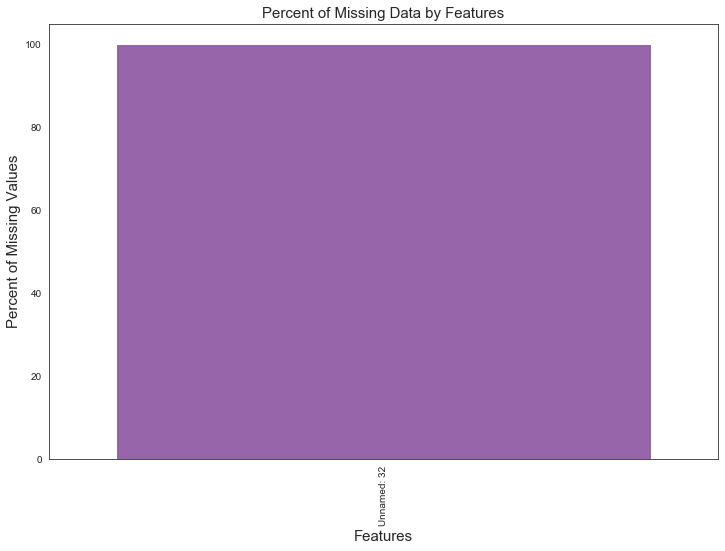

In [10]:
plot_nulls(train)

## Dependent Variable: diagnosis

Frequency of diagnosis :


,Count,Percentage
B,357,62.74
M,212,37.26


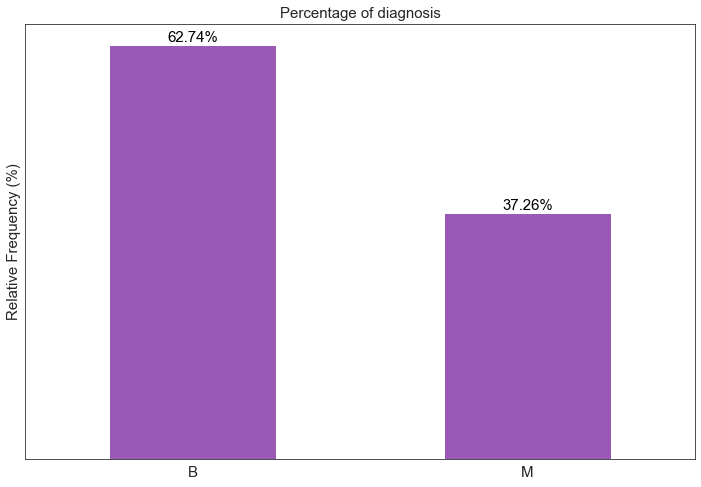

In [11]:
freq_table(train.diagnosis)

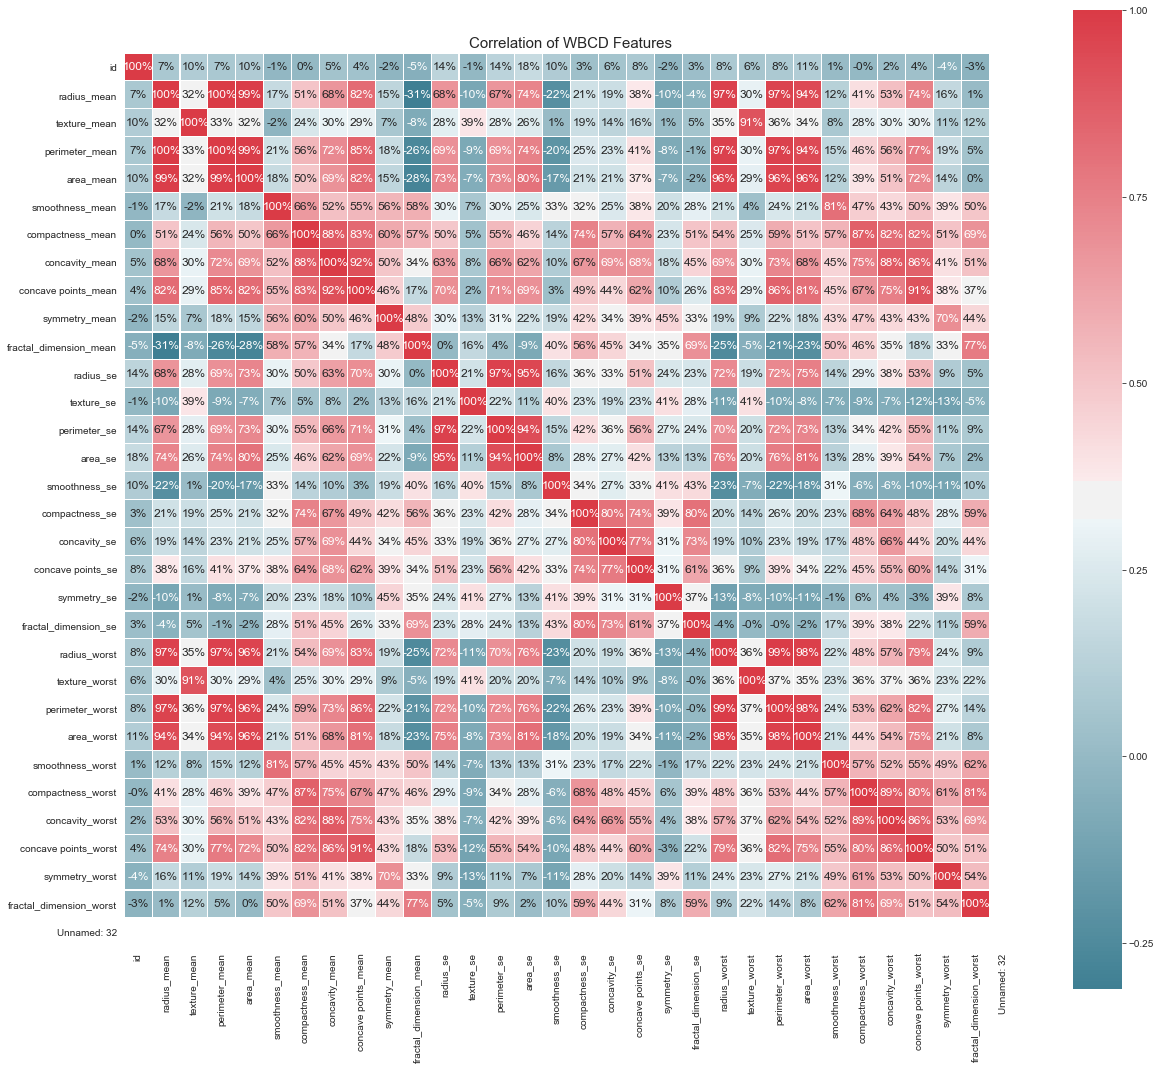

In [12]:
# Create a figure space
plt.subplots(figsize=(20, 18))

# Color
colormap = sns.diverging_palette(220, 10, as_cmap=True) # nice colors

# Create matrix
corr_plot = sns.heatmap(train.corr(),
                        annot=True,
                        cmap=colormap,
                        linewidths=0.20,
                        linecolor='white',
                        vmax=1,
                        square=True,
                        fmt='.0%', #'.1g',
                        annot_kws={'size': 12})

corr_plot
plt.title('Correlation of WBCD Features', y=1.05, size=15)
plt.show()

There are some multicollinearity that we have to be aware of. Many of the red and darker shaded teal is what we should be concerned about.

- In statistics, the correlation coefficient r measures the strength and direction of a linear relationship. don't get this mixed upwith coefficient of determination which is the r^2 which shows percentage of variation in y which is explained by the x variables.
    - when Pearson's r is close to 1 that means there is a strong relationship between the two variables
    - when Pearson's r is close to 0 that means there is a weak relationship between the two variables

### Coefficient of Determination (R-Squared)

The coefficient of determination provides a 'goodness of fit' measure for the predictions to the observations. This is a value between 0 and 1. It's the proportion of the variance in the dependent variable (y) that is predictable from the independent variable (x).

In [13]:
# Create a new feature so we could check correlation
train['Malignant'] = np.where(train['diagnosis']=='M', 1 ,0)

In [14]:
# Top numeric features
r_squared = train.corr()**2
r_squared_df = pd.DataFrame(r_squared.Malignant.sort_values(ascending=False))
r_squared_df['RsqRank'] = r_squared_df['Malignant'].rank(ascending=False)
r_squared_df

,Malignant,RsqRank
Malignant,1.000000,1.0
concave points_worst,0.629747,2.0
perimeter_worst,0.612955,3.0
concave points_mean,0.603129,4.0
radius_worst,0.602880,5.0
perimeter_mean,0.551508,6.0
area_worst,0.538499,7.0
radius_mean,0.532942,8.0
area_mean,0.502658,9.0
concavity_mean,0.484917,10.0


Looks like there aren't any features that are too correlated. 70% is still pretty close but we will leave it for now. We might remove anything below ID.

## radius_mean vs. radius_worst

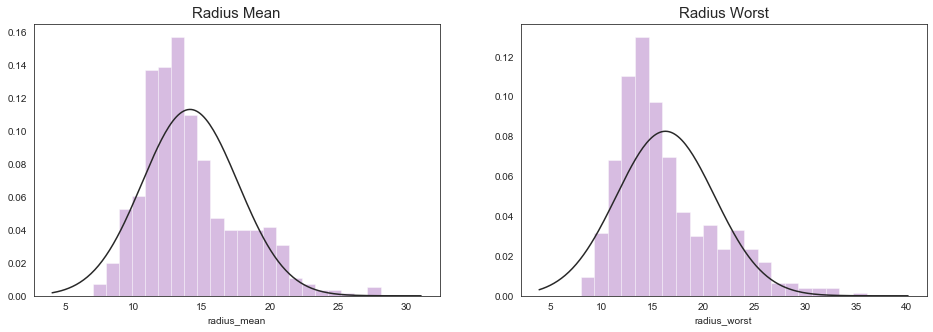

In [15]:
# Create figure space
fig, ax = plt.subplots(figsize=(16, 5), ncols=2, nrows=1)

### Create histograms
## Use flatten() for sns objects:
# The solution is to expand/flatten make your 2d axes object and then directly iterate over it which 
# gives you individual subplot, one at a time.
ax1 = sns.distplot(train.radius_mean, kde=False, fit=norm, ax=ax[0])  #ax=ax.flatten()[0])
ax2 = sns.distplot(train.radius_worst, kde=False, fit=norm, ax=ax[1]) #ax=ax.flatten()[1])

# Set plot features
ax1.set_title('Radius Mean', fontsize=15)
ax2.set_title('Radius Worst', fontsize=15)
plt.show()

Distribution shape between the two features look almost exactly the same.

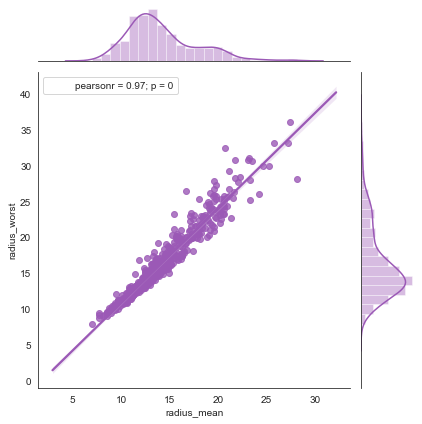

In [16]:
# Another plot
sns.jointplot('radius_mean', 'radius_worst', data=train, kind='regg').annotate(stats.pearsonr)
plt.show()

Strength looks pretty strong between the two features and they also show a positive correlation in it's direction.

## radius_mean

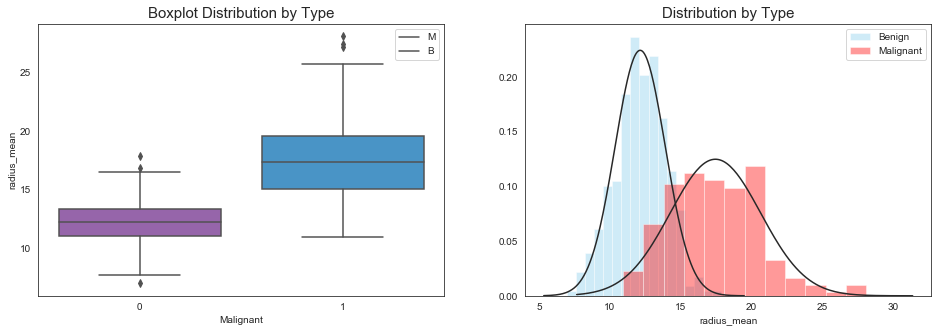

In [17]:
# Create figure space
fig, ax = plt.subplots(figsize=(16, 5), ncols=2, nrows=1)

# Create boxplots
ax1 = sns.boxplot(y=train.radius_mean,
                  x=train.Malignant,
                  data=train,
                  ax=ax[0])

ax2 = sns.distplot(train[train.Malignant==0].radius_mean, color='skyblue', label='Benign', kde=False, fit=norm, ax=ax[1])
ax2 = sns.distplot(train[train.Malignant==1].radius_mean, color='red', label='Malignant', kde=False, fit=norm, ax=ax[1])

# Set plot features
ax1.set_title('Boxplot Distribution by Type', fontsize=15)
ax2.set_title('Distribution by Type', fontsize=15)
ax1.legend(labels=['M','B'], loc='best')
# ax2.legend(labels=['Blue - B','Red - M'], loc='best')
ax2.legend()

plt.show()

Malignant tumors has a larger mean size that shows in both plots. We can assume that the bigger tumors usually indicate malignancy but it's not always the case so we have to take into account other features to validify our assumptions.

## radius_mean vs. area_mean

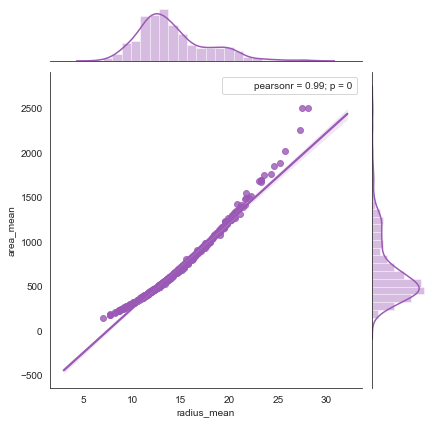

In [18]:
# Correlation with histogram
sns.jointplot('radius_mean', 'area_mean', data=train, kind='regg').annotate(stats.pearsonr)
plt.show()

When radius mean increases, area mean also increases. Therefore, they are positively correlated with each other.

Let's check using pearson's correlation with the definition explained above with the correlation plot.

In [19]:
# Use corr() to get the correlation
area_corr_table = train.loc[:, ['radius_mean', 'area_mean']].corr(method='pearson')

# Calculate the covariance
area_corr = train.radius_mean.cov(train.area_mean)/(train.radius_mean.std()*train.area_mean.std())

# Print results
print('Pearson Correlation Table: ')
print(area_corr_table)
print('Pearson Correlation: ', area_corr)

Pearson Correlation Table: 
             radius_mean  area_mean
radius_mean     1.000000   0.987357
area_mean       0.987357   1.000000
Pearson Correlation:  0.9873571700566123


The pearson correlation between radius_mean and area_mean is almost ~0.99 which means that they are positively correlated with each other and the strength of the relationship between the two features is extremely strong. I would make sense that the larger the area, the larger the radius.

In [20]:
# Spearman's correlation
ranked_data = train.rank()
spearman_corr = ranked_data.loc[:,['area_mean', 'radius_mean']].corr(method='pearson')
print('Spearman''s correlation: ')
print(spearman_corr)

Spearmans correlation: 
             area_mean  radius_mean
area_mean     1.000000     0.999602
radius_mean   0.999602     1.000000


Pearson correlation can be affected by outliers so spearman's correlation is more robust and is an alternative.

## Hypothesis Testing: are the mean differences between radius_mean and area_mean significant?

In [21]:
t_statistic, pvalue = stats.ttest_rel(train.radius_mean, train.area_mean)
print('T-Statistic: {:.2f}\nP-value: {}'.format(t_statistic, pvalue))

T-Statistic: -43.87
P-value: 1.5253492492559045e-184


So a typical answer based on these two values is: since the p-value is less than the alpha 0.05 (threshold), we can reject the null hypothesis (radius_mean is not significant with area_mean) and accept the alternative hypothesis. There is enough evidence indicating that the two features are significant with each other (if one size increases then the other will as well).

## Jitter plot showing multiple features

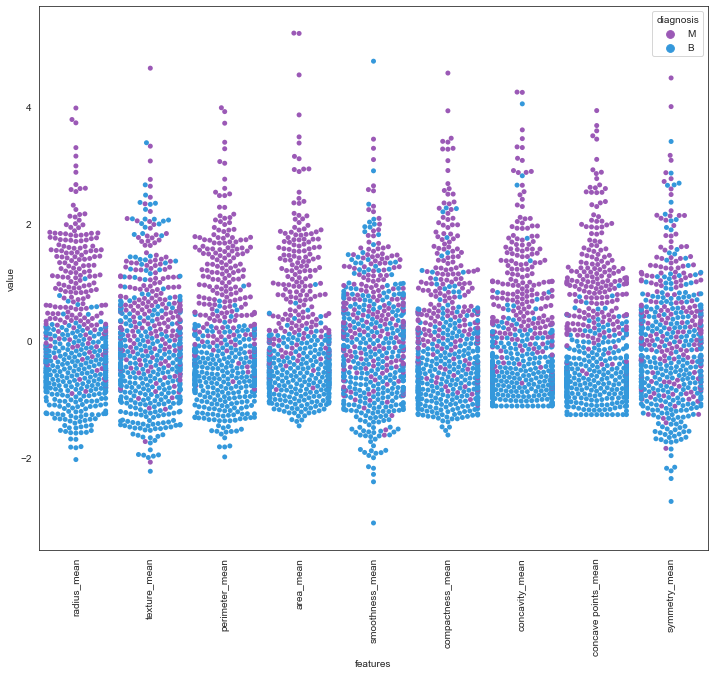

In [22]:
# Split the data so we can use pd.melt()
temp_y = train.diagnosis
temp_x = train.drop('diagnosis', axis=1)

# Standardization
train_norm = (temp_x - temp_x.mean()) / (temp_x.std())
train_norm_new = pd.concat([temp_y, train_norm.iloc[:, 1:10]], axis=1)

# Melt
data = pd.melt(train_norm_new,
               id_vars='diagnosis',
               var_name='features',
               value_name='value')

# Set figure space
plt.figure(figsize=(12, 10))

# Create swarm plot (another version of jitter)
sns.swarmplot(x='features', y='value', hue='diagnosis', data=data)
plt.xticks(rotation=90)
plt.show()

Malignant classified tumors are very prominent as it has higher spread of points that is also larger in every feature with a few outliers in the benign group.

----------

## Modeling preparation

In [15]:
print('=========== Data Summary ===========')
# Split data
y = train[['Malignant']]
X = train.drop(['id', 'diagnosis', 'Malignant', 'texture_se', 'symmetry_se', 'Unnamed: 32'], axis=1)

print('Feature Data: ', X.shape)
print('Label Data: ', y.shape)

# Split into train and test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=100)

print('Training Data Shape:', X_train.shape)
print('Testing Data Shape:', X_test.shape)

print('Training Output Shape:', y_train.shape)
print('Testing Output Shape:', y_test.shape)

=========== Data Summary ===========
Feature Data:  (569, 28)
Label Data:  (569, 1)
Training Data Shape: (398, 28)
Testing Data Shape: (171, 28)
Training Output Shape: (398, 1)
Testing Output Shape: (171, 1)


In [16]:
# Scaler
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Artificial Neural Network: Single Layer Perceptron

In [17]:
accuracy_summary = [] 
loss_summary = [] 
stop_early = 0 

In [21]:
# Define model parameters
LEARNING_RATE = 0.1
BATCH_SIZE = 100
EPOCHS = 10001

# Define how many inputs and outputs are in our neural network
number_of_inputs = 28
number_of_outputs = 1
seed = 100

# Number of nodes in each layer
layer_1_nodes = 1

# Create placeholders for X / Y variables
X = tf.placeholder(tf.float32, shape=[None, number_of_inputs])
Y = tf.placeholder(tf.float32, shape=[None, number_of_outputs])

# Create weight and bias
weights1 = tf.Variable(tf.random_normal(shape=[number_of_inputs, layer_1_nodes], seed=seed), name='weights1')
biases1 = tf.Variable(tf.random_normal(shape=[layer_1_nodes], seed=seed), name='biases1')

# Create output variable
layer_1_output = tf.nn.sigmoid(tf.matmul(X, weights1) + biases1) # sigmoid for binary classification

# Create cost variable
cost_i = tf.nn.sigmoid_cross_entropy_with_logits(logits=layer_1_output, labels=Y)
cost = tf.reduce_mean(cost_i)

# Create optimizer variable
optimizer = tf.train.GradientDescentOptimizer(learning_rate=LEARNING_RATE).minimize(cost)

# Prediction
prediction = tf.cast(layer_1_output>0.50, dtype=tf.float32)
correct_prediction = tf.equal(prediction, Y)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, dtype=tf.float32))

## Initialize session

In [23]:
################################################
####### Initialize Session
################################################

print('=========== Processing ===========')
feed_dict_train_var = {X: X_train, Y: y_train}
feed_dict_test_var = {X: X_test, Y: y_test}

# Initialize a training session after defining the model
with tf.Session() as session:
    
    # Run the global variable initializer to initialize all variables/layers in the neural network
    session.run(tf.global_variables_initializer())
    
    # Train
    for epoch in range(EPOCHS):
        session.run(optimizer, feed_dict=feed_dict_train_var)
        if epoch % 1000 == 0:
            loss, acc = session.run([cost, accuracy], feed_dict=feed_dict_var)
            print('Epoch: {:5}\tLoss: {:.3f}\tAcc: {:.2%}'.format(epoch, loss, acc))
            
            # Record the results
            loss_summary.append(loss)
            accuracy_summary.append(acc)
            
            # If the model does not improve, stop the training
            if loss < max(loss_summary) and epoch > 100:
                stop_early+=1
                
                # Stop after 10 times
                if stop_early==10:
                    break
                else:
                    stop_early=0
        
        train_acc = session.run(accuracy, feed_dict={X: X_train, Y: y_train})
        test_acc, test_predict, test_correct = session.run([accuracy, prediction, correct_prediction], feed_dict=feed_dict_test_var)
    
    # Print results
    print('=========== Results ===========')
    print('Training Accuracy: ', train_acc)
    print('Test Accuracy: ', test_acc)
    
    session.close()

=========== Processing ===========
Epoch:     0	Loss: 0.740	Acc: 78.64%
Epoch:  1000	Loss: 0.666	Acc: 78.14%
Epoch:  2000	Loss: 0.643	Acc: 85.43%
Epoch:  3000	Loss: 0.631	Acc: 87.94%
Epoch:  4000	Loss: 0.623	Acc: 88.94%
Epoch:  5000	Loss: 0.617	Acc: 90.45%
Epoch:  6000	Loss: 0.612	Acc: 91.21%
Epoch:  7000	Loss: 0.609	Acc: 91.96%
Epoch:  8000	Loss: 0.606	Acc: 92.96%
Epoch:  9000	Loss: 0.603	Acc: 93.22%
Epoch: 10000	Loss: 0.601	Acc: 93.22%
=========== Results ===========
Training Accuracy:  0.9321608
Test Accuracy:  0.9122807


--------

## MultiLayer Perceptron & Principal Component Analysis

In [25]:
train = pd.read_csv('21-breast-cancer.csv')

# Create a new feature
train['Malignant'] = np.where(train['diagnosis']=='M', 1 ,0)

accuracy_summary = [] 
loss_summary = [] 
stop_early = 0 

# Split data
y = train[['Malignant']]
# X = train.drop(['id', 'diagnosis', 'Malignant', 'Unnamed: 32'], axis=1)
X = train.drop(['id', 'diagnosis', 'Malignant', 'texture_se', 'symmetry_se', 'Unnamed: 32'], axis=1)

print('=========== Data Summary ===========')

# Split into train and test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=100)

print('Training Data Shape:', X_train.shape)
print('Testing Data Shape:', X_test.shape)
print('Training Output Shape:', y_train.shape)
print('Testing Output Shape:', y_test.shape)

# Scaler
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# PCA
components = 10
pca = PCA(n_components=components)

# PCA transform
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.fit_transform(X_test)

print('PCA Training Data Shape:', X_train_pca.shape)
print('PCA Testing Data Shape:', X_test_pca.shape)

# Define model parameters
LEARNING_RATE = 0.1
BATCH_SIZE = 100
EPOCHS = 20001
seed = 100

# Define input / output
number_of_inputs = components
number_of_outputs = 1

# Define layer nodes
layer_1_nodes = 64
layer_2_nodes = 128
layer_3_nodes = 128

# Create X / Y placeholders
X = tf.placeholder(tf.float32, shape=[None, number_of_inputs])
Y = tf.placeholder(tf.float32, shape=[None, number_of_outputs])

# Input layer
weights1 = tf.Variable(tf.random_normal(shape=[number_of_inputs, layer_1_nodes], seed=seed), name='weights1')
biases1 = tf.Variable(tf.random_normal(shape=[layer_1_nodes], seed=seed), name='biases1')
layer_1_output = tf.nn.sigmoid(tf.matmul(X, weights1) + biases1)

# Layer 1
weights2 = tf.Variable(tf.random_normal(shape=[layer_1_nodes, layer_2_nodes], seed=seed), name='weights2')
biases2 = tf.Variable(tf.random_normal(shape=[layer_2_nodes], seed=seed), name='biases2')
layer_2_output = tf.nn.sigmoid(tf.matmul(layer_1_output, weights2) + biases2)

# Layer 2
weights3 = tf.Variable(tf.random_normal(shape=[layer_2_nodes, layer_3_nodes], seed=seed), name='weights3')
biases3 = tf.Variable(tf.random_normal(shape=[layer_3_nodes], seed=seed), name='biases3')
layer_3_output = tf.nn.sigmoid(tf.matmul(layer_2_output, weights3) + biases3)

# Output layer
weights4 = tf.Variable(tf.random_normal(shape=[layer_3_nodes, number_of_outputs], seed=seed), name='weights4')
biases4 = tf.Variable(tf.random_normal(shape=[number_of_outputs], seed=seed), name='biases4')
logits = tf.matmul(layer_3_output, weights4) + biases4
final_output = tf.nn.sigmoid(tf.matmul(layer_3_output, weights4) + biases4) # matmul - multiplies every single node

# Create cost variable
cost_i = tf.nn.sigmoid_cross_entropy_with_logits(logits=logits, labels=Y)
cost = tf.reduce_mean(cost_i)

# Create optimizer variable
optimizer = tf.train.GradientDescentOptimizer(learning_rate=LEARNING_RATE).minimize(cost)

# Create prediction variables
prediction = tf.cast(final_output>0.50, dtype=tf.float32)
correct_prediction = tf.equal(prediction, Y)
accuracy  = tf.reduce_mean(tf.cast(correct_prediction, dtype=tf.float32))

################################################
####### Initialize Session
################################################

train_x = X_train
train_y = y_train
test_x = X_test
test_y = y_test

print('=========== Processing ===========')
feed_dict_train_var = {X: X_train_pca, Y: y_train}
feed_dict_test_var = {X: X_test_pca, Y: y_test}

# Initialize a training session after defining the model
with tf.Session() as session:
    
    # Run the global variable initializer to initialize all variables/layers in the neural network
    session.run(tf.global_variables_initializer())
    
    # Train
    for epoch in range(EPOCHS):
        session.run(optimizer, feed_dict=feed_dict_train_var)
        if epoch % 1000 == 0:
            loss, acc = session.run([cost, accuracy], feed_dict=feed_dict_train_var)
            print('Epoch: {:5}\tLoss: {:.3f}\tAcc: {:.2%}'.format(epoch, loss, acc))
            
            # Record the results
            loss_summary.append(loss)
            accuracy_summary.append(acc)
            
            # If the model does not improve, stop the training
            if loss < max(loss_summary) and epoch > 100:
                stop_early+=1
                
                # Stop after 10 times
                if stop_early==10:
                    break
                else:
                    stop_early=0
        
        train_acc = session.run(accuracy, feed_dict=feed_dict_train_var)
        test_acc, test_predict, test_correct = session.run([accuracy, prediction, correct_prediction], feed_dict=feed_dict_test_var)
        
    # Print results
    print('=========== Results ===========')
    print('Training Accuracy: ', train_acc)
    print('Test Accuracy: ', test_acc)
    
    session.close()

=========== Data Summary ===========
Training Data Shape: (398, 30)
Testing Data Shape: (171, 30)
Training Output Shape: (398, 1)
Testing Output Shape: (171, 1)
PCA Training Data Shape: (398, 10)
PCA Testing Data Shape: (171, 10)
=========== Processing ===========
Epoch:     0	Loss: 9.042	Acc: 35.93%
Epoch:  1000	Loss: 0.058	Acc: 98.49%
Epoch:  2000	Loss: 0.048	Acc: 98.74%
Epoch:  3000	Loss: 0.042	Acc: 98.74%
Epoch:  4000	Loss: 0.038	Acc: 98.74%
Epoch:  5000	Loss: 0.034	Acc: 98.74%
Epoch:  6000	Loss: 0.031	Acc: 98.99%
Epoch:  7000	Loss: 0.027	Acc: 98.99%
Epoch:  8000	Loss: 0.024	Acc: 98.99%
Epoch:  9000	Loss: 0.022	Acc: 99.25%
Epoch: 10000	Loss: 0.020	Acc: 99.50%
Epoch: 11000	Loss: 0.018	Acc: 99.75%
Epoch: 12000	Loss: 0.016	Acc: 99.75%
Epoch: 13000	Loss: 0.014	Acc: 99.75%
Epoch: 14000	Loss: 0.013	Acc: 99.75%
Epoch: 15000	Loss: 0.012	Acc: 100.00%
Epoch: 16000	Loss: 0.011	Acc: 100.00%
Epoch: 17000	Loss: 0.010	Acc: 100.00%
Epoch: 18000	Loss: 0.009	Acc: 100.00%
Epoch: 19000	Loss: 0.008	Acc

In [71]:
''' 
Without removal of low correlated features

=========== Data Summary ===========
Training Data Shape: (398, 30)
Testing Data Shape: (171, 30)
Training Output Shape: (398, 1)
Testing Output Shape: (171, 1)
PCA Training Data Shape: (398, 10)
PCA Testing Data Shape: (171, 10)
=========== Processing ===========
Epoch:     0	Loss: 9.042	Acc: 35.93%
Epoch:  1000	Loss: 0.058	Acc: 98.49%
Epoch:  2000	Loss: 0.048	Acc: 98.74%
Epoch:  3000	Loss: 0.042	Acc: 98.74%
Epoch:  4000	Loss: 0.038	Acc: 98.74%
Epoch:  5000	Loss: 0.034	Acc: 98.74%
Epoch:  6000	Loss: 0.031	Acc: 98.99%
Epoch:  7000	Loss: 0.027	Acc: 98.99%
Epoch:  8000	Loss: 0.024	Acc: 98.99%
Epoch:  9000	Loss: 0.022	Acc: 99.25%
Epoch: 10000	Loss: 0.020	Acc: 99.50%
Epoch: 11000	Loss: 0.018	Acc: 99.75%
Epoch: 12000	Loss: 0.016	Acc: 99.75%
Epoch: 13000	Loss: 0.014	Acc: 99.75%
Epoch: 14000	Loss: 0.013	Acc: 99.75%
Epoch: 15000	Loss: 0.012	Acc: 100.00%
Epoch: 16000	Loss: 0.011	Acc: 100.00%
Epoch: 17000	Loss: 0.010	Acc: 100.00%
Epoch: 18000	Loss: 0.009	Acc: 100.00%
Epoch: 19000	Loss: 0.008	Acc: 100.00%
Epoch: 20000	Loss: 0.007	Acc: 100.00%
=========== Results ===========
Training Accuracy:  1.0
Test Accuracy:  0.90643275
'''
print()

-------

## Machine Learning

Repopuate a clean set of the data and perform PCA, Pipeline, and CV with any supervised classification algorithm (Log/RF/SVM).

In [23]:
train = pd.read_csv('21-breast-cancer.csv')

# Create a new feature
train['Malignant'] = np.where(train['diagnosis']=='M', 1 ,0)

# Split data
y = train[['Malignant']]
X = train.drop(['id', 'diagnosis', 'Malignant', 'texture_se', 'symmetry_se', 'Unnamed: 32'], axis=1)

print('=========== Data Summary ===========')

# Split into train and test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=100)

print('Training Data Shape:', X_train.shape)
print('Testing Data Shape:', X_test.shape)
print('Training Output Shape:', y_train.shape)
print('Testing Output Shape:', y_test.shape)

# Scaler
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# PCA
components = 20
pca = PCA(n_components=components)

# PCA transform
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.fit_transform(X_test)

print('PCA Training Data Shape:', X_train_pca.shape)
print('PCA Testing Data Shape:', X_test_pca.shape)

=========== Data Summary ===========
Training Data Shape: (398, 28)
Testing Data Shape: (171, 28)
Training Output Shape: (398, 1)
Testing Output Shape: (171, 1)
PCA Training Data Shape: (398, 15)
PCA Testing Data Shape: (171, 15)


## Random forest

Accuracy:  0.9649122807017544


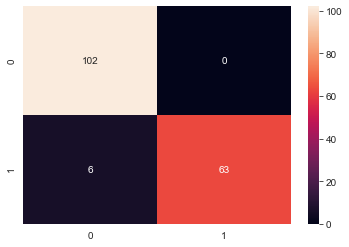

In [24]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score,confusion_matrix
from sklearn.metrics import accuracy_score

# Train / test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100)

# Random Forest
rf_model = RandomForestClassifier(random_state=100)      
rf_model = rf_model.fit(X_train, y_train)

# Evaluate
rf_acc = accuracy_score(y_test, rf_model.predict(X_test))
print('Accuracy: ', rf_acc)

# Confusion Matrix
cm = confusion_matrix(y_test, rf_model.predict(X_test))
sns.heatmap(cm, 
            annot=True,
            fmt='d')
plt.show()

~ 96% is actually better than our PCA/MLP model that had a 90% testing accuracy.

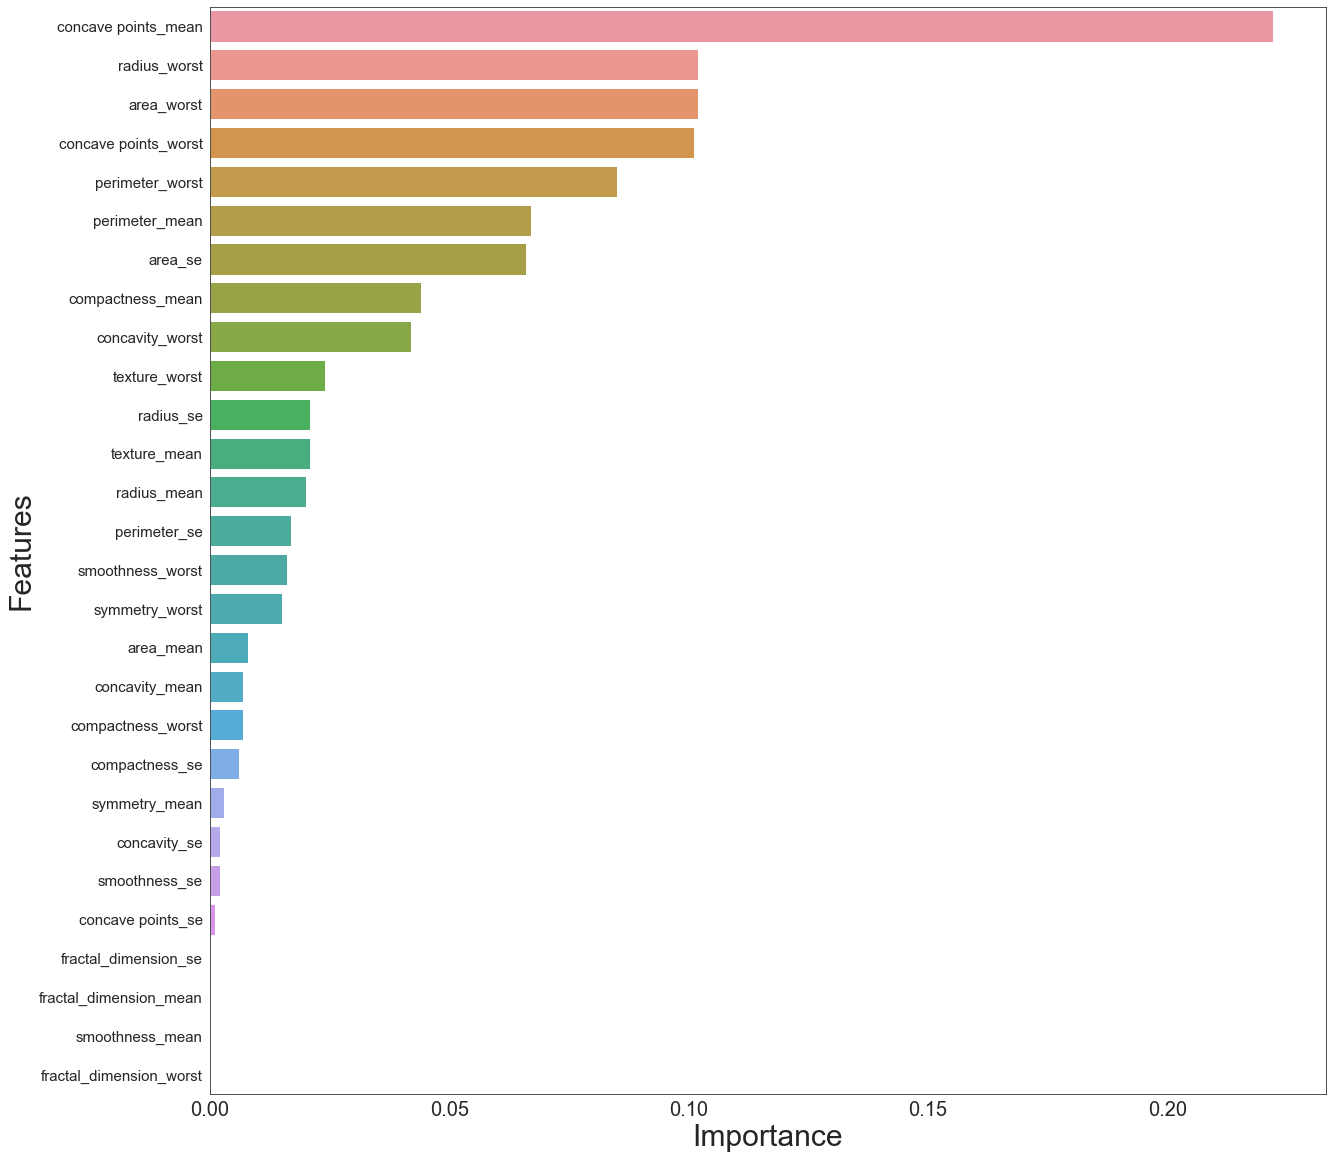

In [25]:
# Create plots for view feature importance graphically
plt.figure(figsize=(20, 20))
fig.suptitle('Feature Importance', fontsize=20)

headers = X_train.columns
models_used = [rf_model]
model_names = ['RF']

# https://www.geeksforgeeks.org/zip-in-python/
# feature_importance(rf_model).plot.barh(title='RF', fontsize=15, color='seagreen')
sns.barplot(x='Importance',
            y=feature_importance(rf_model).index,
            data=feature_importance(rf_model))

# Set plot features
plt.xlabel('Importance', fontsize=30)
plt.ylabel('Features', fontsize=30)
plt.xticks(fontsize=20)
plt.yticks(fontsize=15)
plt.show()

In [26]:
# Feature importance data frame
feat_imp = pd.DataFrame(feature_importance(rf_model))
feat_imp['FeatImpRank'] = feat_imp['Importance'].rank(ascending=False)

# Compare correlation values with random forest feature importance
combined_feat_rank_df = pd.merge(feat_imp, r_squared_df, left_index=True, right_index=True)
combined_feat_rank_df['Rank Difference'] = combined_feat_rank_df.FeatImpRank - combined_feat_rank_df.RsqRank
combined_feat_rank_df

,Importance,FeatImpRank,Malignant,RsqRank,Rank Difference
concave points_mean,0.222,1.0,0.603129,4.0,-3.0
radius_worst,0.102,2.5,0.602880,5.0,-2.5
area_worst,0.102,2.5,0.538499,7.0,-4.5
concave points_worst,0.101,4.0,0.629747,2.0,2.0
perimeter_worst,0.085,5.0,0.612955,3.0,2.0
perimeter_mean,0.067,6.0,0.551508,6.0,0.0
area_se,0.066,7.0,0.300563,16.0,-9.0
compactness_mean,0.044,8.0,0.355852,12.0,-4.0
concavity_worst,0.042,9.0,0.435086,11.0,-2.0
texture_worst,0.024,10.0,0.208760,17.0,-7.0


## Multiple models & cross-validation

In [38]:
# Import Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import  RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from xgboost import XGBClassifier

# Importing other tools
from sklearn.metrics import confusion_matrix, classification_report, make_scorer
from sklearn.metrics import accuracy_score, recall_score, precision_recall_curve
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import RandomizedSearchCV

# Defining parameters
seed=100
n_folds = 5
skf = StratifiedKFold(n_splits=n_folds, random_state=seed)
scaler = StandardScaler()

# Create models
xgb = XGBClassifier(random_state=seed)
lr = LogisticRegression(solver='lbfgs', random_state=seed)
svc = SVC(random_state=seed, probability=True)
gb = GradientBoostingClassifier(random_state=seed)
knn = KNeighborsClassifier()
rf = RandomForestClassifier(random_state=seed)      

# Model list
model_list = [xgb, lr, svc, gb, knn, rf]
model_names = ['XGB', 'Logistic Regression', 'Support Vector',
               'Gradient Boosting','K-Neighbors', 'Random Forest']

In [31]:
train_size = X_train.shape[0]
n_models = len(model_list)
oof_pred = np.zeros((train_size, n_models))
scores = []

print('Training Size: ', train_size)
print('Models Training: ', n_models)

Training Size:  398
Models Training:  6


In [40]:
# Loop through model list
for n, model in enumerate(model_list):
    model_pipeline = Pipeline(steps=[('scaler', scaler),
                                      ('model', model)])
    
#     random_search = RandomizedSearchCV(model_pipeline, param_distributions=prams, cv=n_folds)

    # Accuracy
    accuracy = np.zeros(n_folds)
    recall = np.zeros(n_folds)
    
    # Loop through models with training data
    for i, (train_ix, test_ix) in enumerate(skf.split(X_train, y_train)):
        x_tr, y_tr = X_train.iloc[train_ix], y_train.iloc[train_ix]
        x_tes, y_tes = X_train.iloc[test_ix], y_train.iloc[test_ix]
        
        # Fit the model
        model_pipeline.fit(x_tr, y_tr)
        tes_pred = model_pipeline.predict(x_tes)
        
        # Predict probability
        oof_pred[test_ix, n] = model_pipeline.predict_proba(x_tes)[:, 1]
        
        # Fold accuracy
        fold_acc = accuracy_score(y_tes, tes_pred)
        fold_rec = recall_score(y_tes, tes_pred)
        
        # Add score into list
        accuracy[i] = fold_acc
        recall[i] = fold_rec
        
    # Append accuracy and recall
    scores.append({'Accuracy'          : accuracy.mean(),
                   'Recall'            : recall.mean()})

TypeError: __init__() missing 1 required positional argument: 'param_distributions'

In [36]:
# Results
measure_cols = ['Accuracy', 'Recall']
final_scores = pd.DataFrame(columns=measure_cols)

# Loop through the scores
for name, score in zip(model_names, scores):
    new_row = pd.Series(data=score, name=name)
    final_scores = final_scores.append(new_row)
    
final_scores = final_scores.sort_values('Recall', ascending=False)
final_scores

,Accuracy,Recall
Support Vector,0.977310,0.957882
Logistic Regression,0.974905,0.950985
XGB,0.959715,0.936946
Random Forest,0.954747,0.929803
K-Neighbors,0.964842,0.923153
Gradient Boosting,0.939652,0.922906


In [71]:
# Save model
from sklearn.externals import joblib
joblib.dump(svc, '../Models/breast_cancer_svc.pkl')
joblib.dump(lr, '../Models/breast_cancer_lr.pkl')
joblib.dump(xgb, '../Models/breast_cancer_xgb.pkl')
joblib.dump(rf, '../Models/breast_cancer_rf.pkl')

['../Models/breast_cancer_rf.pkl']

Our earlier random forest actually did a little bit better on it's first run. Using CV and scaled data is a more standard method overall. SV and LR did well with 97%. 

--------

## Random forest randomized cv (pipeline)

Accuracy:  0.9649122807017544


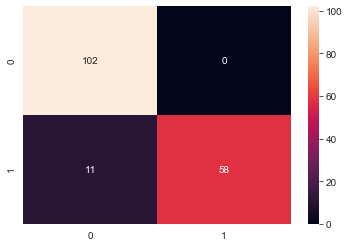

In [56]:
# Parameter grid
param_dist = {'model__max_depth': range(3, 8),
              'model__max_features': range(8, 21),
              'model__min_samples_split': range(2, 11)}

# PCA
components = 20
pca = PCA(n_components=components)

# RF
rf_new = RandomForestClassifier(random_state=200)   

model_pipeline = Pipeline(steps=[('scaler', scaler),
                                 ('pca', pca),
                                 ('model', rf_new)]) 
# Randomized cv
random_search = RandomizedSearchCV(estimator=model_pipeline,
                                   param_distributions=param_dist,
                                   n_iter=20,
                                   cv=10)

# Fit
random_search.fit(X_train, y_train)

# Evaluate
rf_new_acc = accuracy_score(y_test, rf_model.predict(X_test))
print('Accuracy: ', rf_new_acc)

# Confusion Matrix
cm = confusion_matrix(y_test, random_search.predict(X_test))
sns.heatmap(cm, 
            annot=True,
            fmt='d')
plt.show()

In [57]:
# https://stackoverflow.com/questions/34889110/random-forest-with-gridsearchcv-error-on-param-grid/34890246
sorted(model_pipeline.get_params().keys())

['memory',
 'model',
 'model__bootstrap',
 'model__class_weight',
 'model__criterion',
 'model__max_depth',
 'model__max_features',
 'model__max_leaf_nodes',
 'model__min_impurity_decrease',
 'model__min_impurity_split',
 'model__min_samples_leaf',
 'model__min_samples_split',
 'model__min_weight_fraction_leaf',
 'model__n_estimators',
 'model__n_jobs',
 'model__oob_score',
 'model__random_state',
 'model__verbose',
 'model__warm_start',
 'pca',
 'pca__copy',
 'pca__iterated_power',
 'pca__n_components',
 'pca__random_state',
 'pca__svd_solver',
 'pca__tol',
 'pca__whiten',
 'scaler',
 'scaler__copy',
 'scaler__with_mean',
 'scaler__with_std',
 'steps',
 'verbose']

--------

## Check parameters, scores

In [58]:
random_search.best_score_

0.9447236180904522

In [59]:
random_search.best_params_

{'model__min_samples_split': 8,
 'model__max_features': 8,
 'model__max_depth': 7}

In [60]:
random_search.best_estimator_

Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('pca',
                 PCA(copy=True, iterated_power='auto', n_components=20,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('model',
                 RandomForestClassifier(bootstrap=True, class_weight=None,
                                        criterion='gini', max_depth=7,
                                        max_features=8, max_leaf_nodes=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=8,
                                        min_weight_fraction_leaf=0.0,
                                        n_estimators=10, n_jobs=None,
                                        oob_score=False, random_state=20

In [65]:
print(random_search.cv_results_['mean_test_score'])
print(random_search.cv_results_['params'])

[0.9321608  0.93969849 0.93969849 0.92964824 0.93467337 0.93718593
 0.9321608  0.9321608  0.93718593 0.94472362 0.93718593 0.91959799
 0.9321608  0.92211055 0.9321608  0.92964824 0.92964824 0.93969849
 0.9321608  0.93467337]
[{'model__min_samples_split': 10, 'model__max_features': 17, 'model__max_depth': 4}, {'model__min_samples_split': 7, 'model__max_features': 11, 'model__max_depth': 5}, {'model__min_samples_split': 6, 'model__max_features': 13, 'model__max_depth': 5}, {'model__min_samples_split': 3, 'model__max_features': 15, 'model__max_depth': 3}, {'model__min_samples_split': 7, 'model__max_features': 17, 'model__max_depth': 7}, {'model__min_samples_split': 9, 'model__max_features': 15, 'model__max_depth': 6}, {'model__min_samples_split': 9, 'model__max_features': 14, 'model__max_depth': 3}, {'model__min_samples_split': 10, 'model__max_features': 14, 'model__max_depth': 3}, {'model__min_samples_split': 2, 'model__max_features': 15, 'model__max_depth': 4}, {'model__min_samples_spli

In [68]:
max_depth = [item['model__max_depth'] for item in random_search.cv_results_['params']]
scores = list(random_search.cv_results_['mean_test_score'])
d = pd.DataFrame([max_depth, scores]).T
d.columns = ['Max Depth', 'Score']
d.groupby(['Max Depth']).mean()

,Score
Max Depth,
3.0,0.932161
4.0,0.932663
5.0,0.932998
6.0,0.931323
7.0,0.937814


In [70]:
# Save model
joblib.dump(random_search, '../Models/rf_random_search_pca.pkl')

['rf_random_search_pca.pkl']